# Notes
This Jupyter Notebook provides you with some basic scaffolding to get you started on the [A2: Gesture Recognizer assignment](https://canvas.uw.edu/courses/1199409/assignments/4176980). In particular, I wrote some parser code and some initial data structures to parse and load the gesture logs recorded with the [A2: Gesture Logger](https://github.com/jonfroehlich/CSE590Sp2018/tree/master/A02-GestureLogger).

## Getting Started
1. The first thing you need to do is to change the logPath variable to point to the directory with your gesture logs. Scroll down to the "Load the Data" cell
2. Then, you should be able to select Cell->Run All in the File Menu above and the data should be read in.
3. Hopefully, in class, we will have time to visualize and analyze these signals a bit

## Dynamic Time Warping
If you choose to explore Dynamic Time Warping (DTW), I recommend fastdtw. You can install this by typing the following in cell:
```
import sys
!{sys.executable} -m pip install fastdtw
```
See https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/ for more details

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
        
        self.x_nopad = self.x
        self.y_nopad = self.y
        self.z_nopad = self.z
   
        xSquared = np.multiply(self.x , self.x)
        ySquared = np.multiply(self.y, self.y)
        zSquared = np.multiply(self.z, self.z)
        self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        self.mag_nopad = self.mag
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Gyroscope", *parsedGyroLogData[1:])
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

In [19]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

In [20]:
# Load the data

# You should change the path to the location of the log files on your system
# logPath = '/Users/jonf/Dropbox/CSE590_UbiComp/Git/CSE590Sp2018p/A02-GestureRecognizer/JupyterAnalysis/GestureLogs'
# logPath = "D:\Dropbox\CSE590_UbiComp\Git\CSE590Sp2018\A02-GestureRecognizer\JonGestureLogs"

logPath = './JonGestureLogs'

mapGestureToTrials = parse_and_create_gesture_trials(logPath)

Found 100 csv files in ./JonGestureLogs
Found 10 gestures
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'At Rest'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Max trial length across all gesture is 'At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match


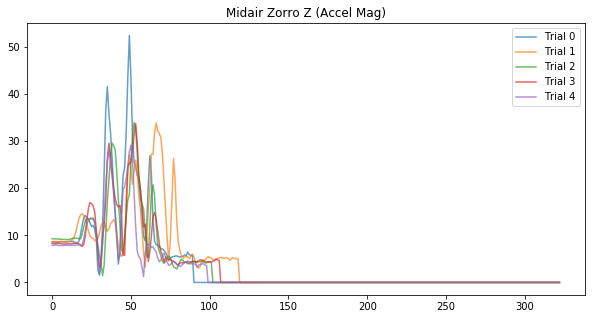

In [21]:
# Now, we need to plot and explore the data. Come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
trialNum = 0
for trial in gestureTrials:
    axes.plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()


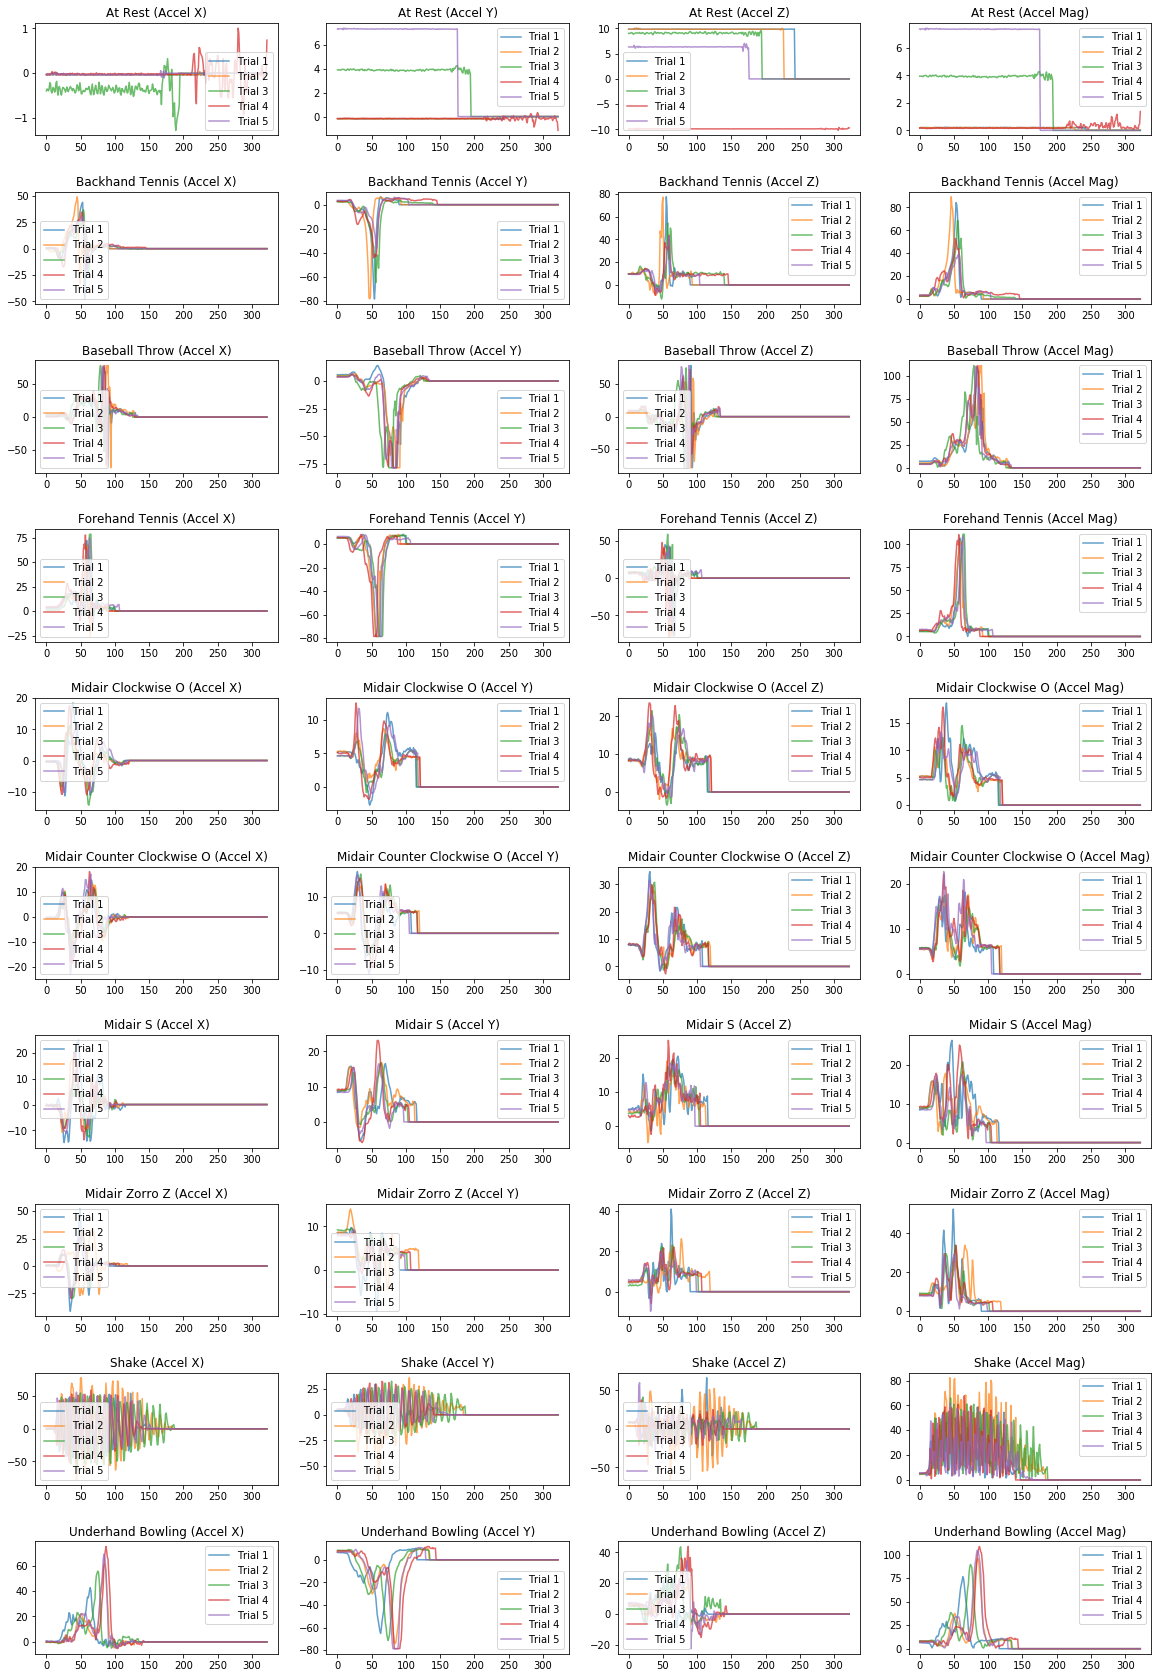

In [22]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1


In [23]:
# In class on Thursday, April 12, I'd like you to start analyzing and comparing these gesture signals.
# Think about:
#  - What kind of filtering might be useful?
#  - What kind of signal transforms? (e.g., ffts)
#  - Is there value in exploring both the accel data AND the gyro data? 
#  - What is the simplest way we can compare two signals? (scroll down and look for distance.euclidean)?
#  - What classes might you want to create to help you keep things organized? (e.g., your k-fold experiments and results)

In [24]:
myLogPath = './GestureLogs'
mapMyGestureToTrials = parse_and_create_gesture_trials(myLogPath)

Found 220 csv files in ./GestureLogs
Found 11 gestures
Found 10 trials for 'Underhand Bowling'
Found 10 trials for 'Midair Clockwise O'
Found 10 trials for 'At Rest'
Found 10 trials for 'Forehand Tennis'
Found 10 trials for 'Midair S'
Found 10 trials for 'Baseball Throw'
Found 10 trials for 'Midair Zorro Z'
Found 10 trials for 'Your Custom Gesture'
Found 10 trials for 'Backhand Tennis'
Found 10 trials for 'Midair Counter Clockwise O'
Found 10 trials for 'Shake'
Max trial length across all gesture is 'Midair S' Trial 5 with 168 sensor events. Resizing all arrays to match


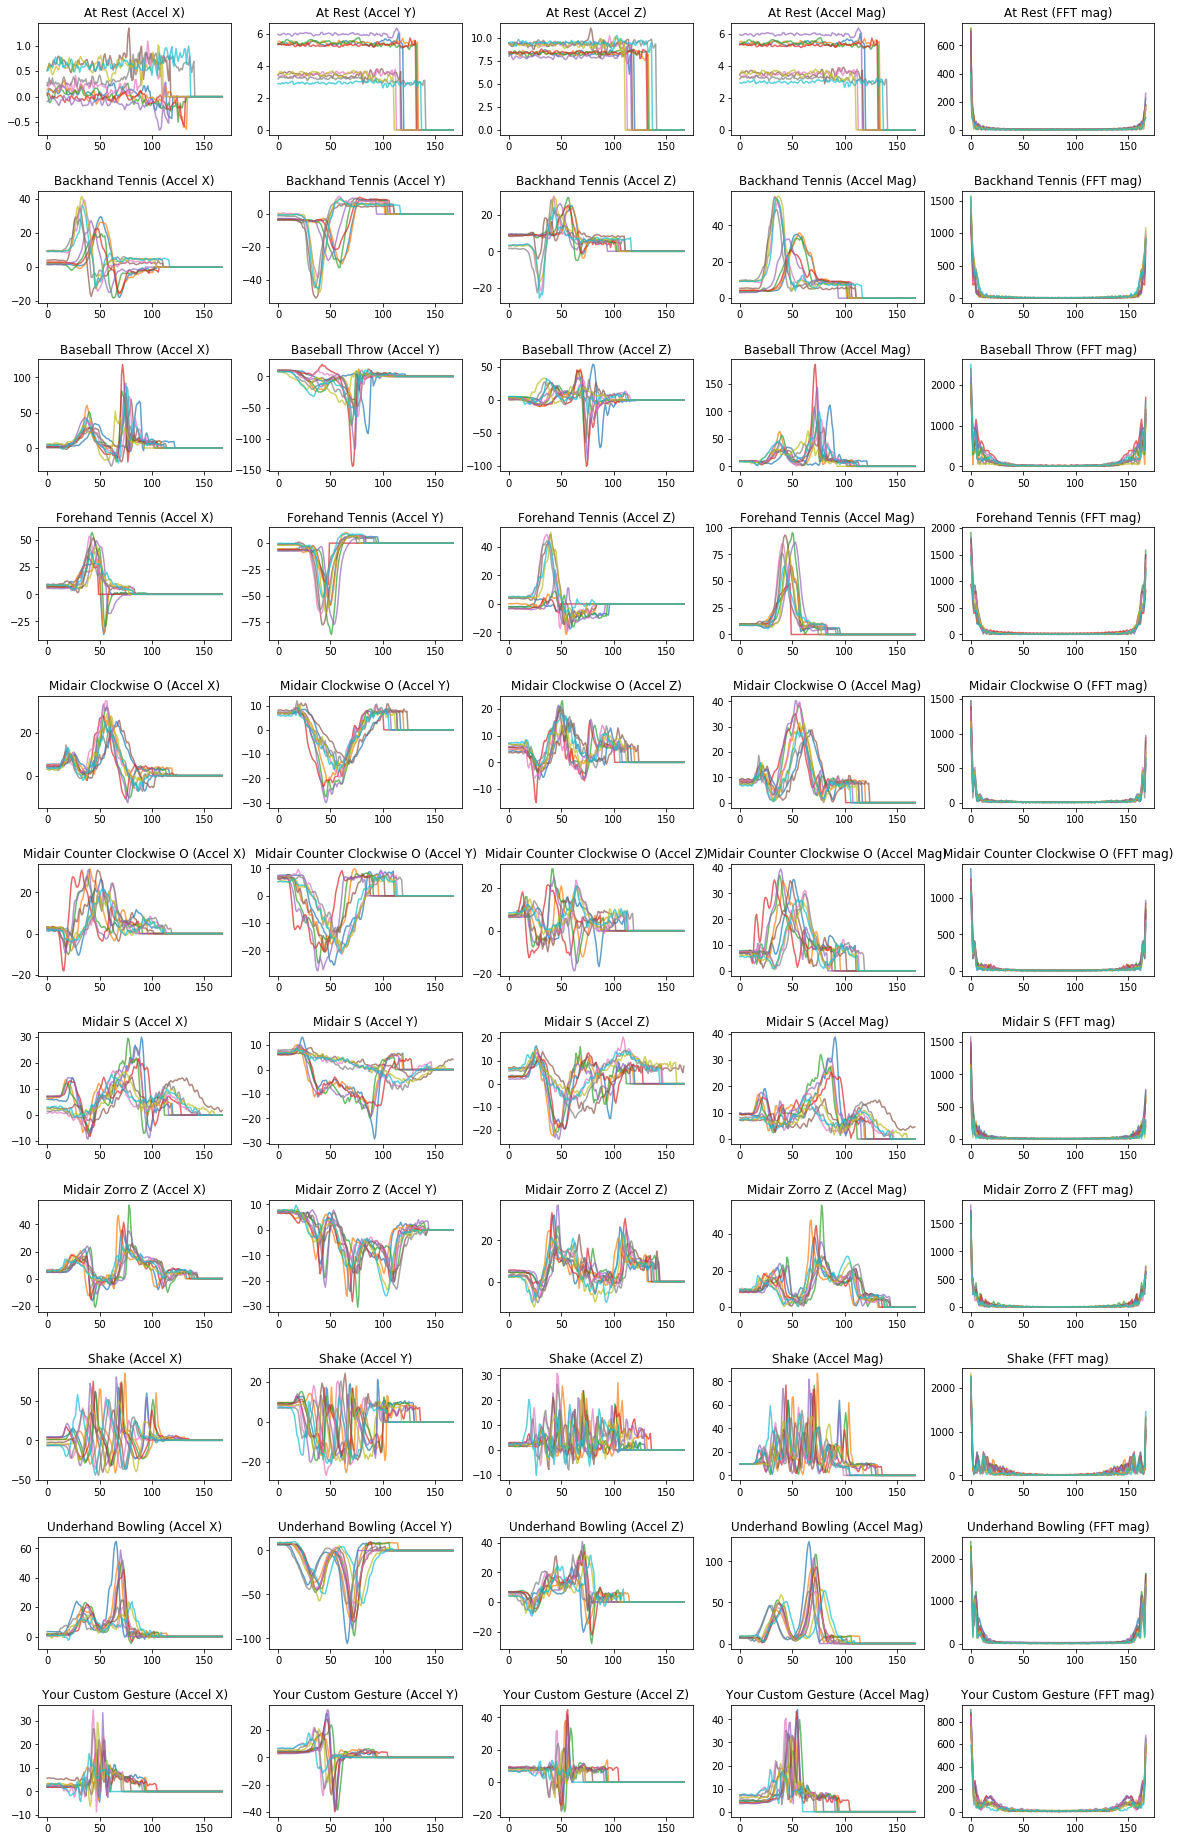

In [25]:
#Chart my gesture logs
fig, axes = plt.subplots(len(mapMyGestureToTrials), 5, figsize=(20, 3 * len(mapMyGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
myGestureNamesSorted = sorted(mapMyGestureToTrials.keys())
for myGestureName in myGestureNamesSorted:
    myGestureTrials = mapMyGestureToTrials[myGestureName]
    trialNum = 1

    for myTrial in myGestureTrials:
        axes[index][0].plot(myTrial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(myTrial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(myTrial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(myTrial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][4].plot(np.absolute(np.fft.fft(myTrial.accel.mag)), alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(myGestureName + " (Accel X)")
#     axes[index][0].legend()
    
    axes[index][1].set_title(myGestureName + " (Accel Y)")
#     axes[index][1].legend()
    
    axes[index][2].set_title(myGestureName + " (Accel Z)")
#     axes[index][2].legend()
    
    axes[index][3].set_title(myGestureName + " (Accel Mag)")
#     axes[index][3].legend()
    
    axes[index][4].set_title(myGestureName + " (FFT mag)")
#     axes[index][4].legend()
    
    index = index + 1


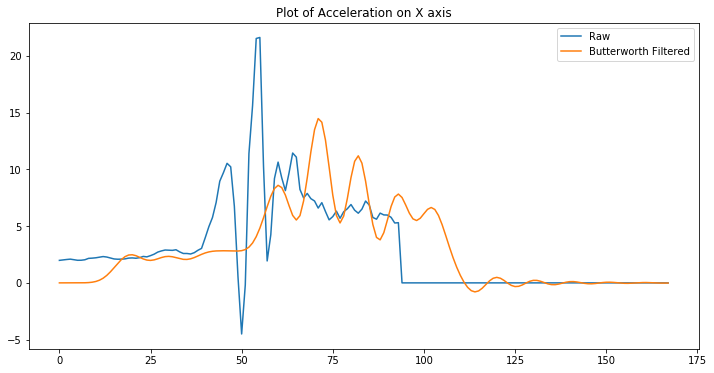

In [26]:
def applyButterWorthLowPassFilter(axis):
    # apply butterworth filter to data
    samplingRate = 3000
    desiredCutOffFreq = 300
    nyquistFreq = samplingRate / 2.0
    desiredCutOffFreqNormalized = desiredCutOffFreq / nyquistFreq
    filterOrder = 14
    b, a = butter(filterOrder, desiredCutOffFreqNormalized, btype='lowpass')
    
    return lfilter(b, a, axis)

#Chart single gesture with butterworth filter
g = mapMyGestureToTrials["Your Custom Gesture"]
t = g[0]

plt.figure(figsize=(12, 6))
plt.plot(t.accel.x, label="Raw")
plt.plot(applyButterWorthLowPassFilter(t.accel.x), label="Butterworth Filtered")
plt.title("Plot of Acceleration on X axis")
plt.legend()
plt.show()

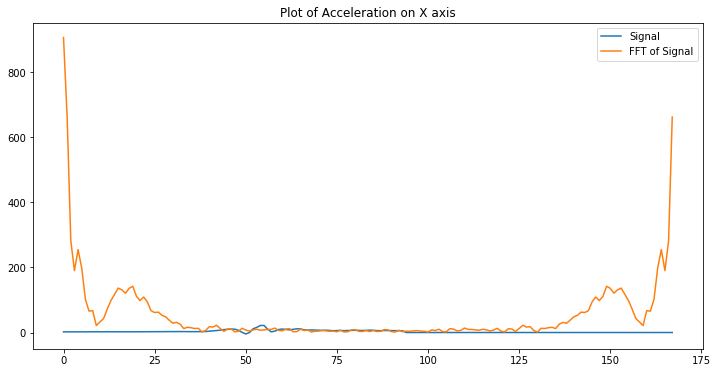

In [27]:
#Chart fft and spectrogram
g = mapMyGestureToTrials["Your Custom Gesture"]
t = g[0]

plt.figure(figsize=(12, 6))
plt.plot(t.accel.x, label="Signal")
plt.plot(np.absolute(np.fft.fft(t.accel.mag)), label="FFT of Signal")
plt.title("Plot of Acceleration on X axis")
plt.legend()
plt.show()

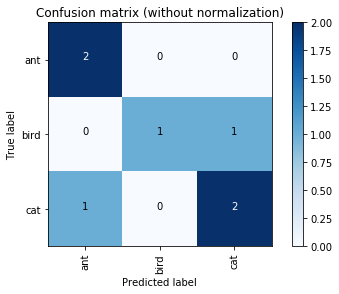

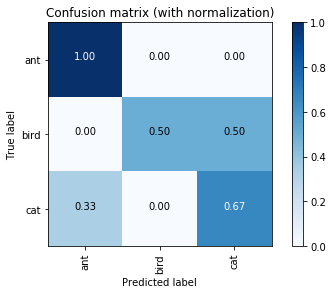

In [28]:
# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ["cat", "ant", "cat", "cat", "ant", "bird", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat", "bird"]
labels=["ant", "bird", "cat"]
cm = confusion_matrix(y_true, y_pred, labels)
plt.figure()
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()

# Model-Based ML Exercises
Here is some code for the in-class exercises on Thurs, April 19

In [29]:
# Given the online discussion about k-fold implementations, I thought I would provide my own. Note that sci-kit learn also 
# has built-in functionality for this (I've never used it but worth checking out):
# http://scikit-learn.org/stable/modules/cross_validation.html
from random import randint

# Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial for that fold
# if createNewKFold is True, returns a new random fold, otherwise returns same fold setup as before 
# (this is to better enable repeat experimentation)
fixedFoldsToMapGestureToTrial = None
def generate_kfolds(mGestureToTrials, numFolds=5, createNewKFold=False):
    global fixedFoldsToMapGestureToTrial
    
    if createNewKFold is False and fixedFoldsToMapGestureToTrial is not None:
        return fixedFoldsToMapGestureToTrial
    
    # Quick check to make sure that there are numFolds of gesture trials for each gesture
    for gestureName, trials in mGestureToTrials.items():
        if numFolds != len(trials):
            raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
                             .format(numFolds, gestureName, len(trials)))


    numGestures = len(mGestureToTrials)
    tmpMapGestureToTrials = dict()
    for gestureName, trials in mGestureToTrials.items():
        tmpMapGestureToTrials[gestureName] = list(trials)
    
    gestureNames = list(mGestureToTrials.keys())

    # create folds
    foldToMapGestureToTrial = list()
    for i in range(0, numFolds):
        curFoldMapGestureToTrial = dict()
        foldToMapGestureToTrial.append(curFoldMapGestureToTrial)
        
        for j in range(0, numGestures):
            curGestureName = gestureNames[j]
            trialList = tmpMapGestureToTrials[curGestureName]
            randTrialIndex = 0
            if (len(trialList) > 0):
                randTrialIndex = randint(0, len(trialList) - 1)

            randTrial = trialList[randTrialIndex]
            curFoldMapGestureToTrial[curGestureName] = randTrial
            del trialList[randTrialIndex]
    
    if fixedFoldsToMapGestureToTrial is None:
        fixedFoldsToMapGestureToTrial = foldToMapGestureToTrial
    
    return foldToMapGestureToTrial

In [30]:
# Print out the folds
numFolds = 5
foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials, numFolds, True)

# debug check folds
foldIndex = 0
print("DEBUG: PRINTING OUT FOLDS")
for fold in foldToMapGestureToTrial:
    print("Fold: ", foldIndex)
    for gestureName, trial in fold.items():
        print("\t Gesture: {} Trial: {}".format(gestureName, trial.trialNum))
    foldIndex = foldIndex + 1

DEBUG: PRINTING OUT FOLDS
Fold:  0
	 Gesture: Backhand Tennis Trial: 2
	 Gesture: Midair Clockwise O Trial: 1
	 Gesture: At Rest Trial: 3
	 Gesture: Midair Zorro Z Trial: 1
	 Gesture: Shake Trial: 3
	 Gesture: Underhand Bowling Trial: 3
	 Gesture: Midair S Trial: 1
	 Gesture: Midair Counter Clockwise O Trial: 3
	 Gesture: Baseball Throw Trial: 2
	 Gesture: Forehand Tennis Trial: 0
Fold:  1
	 Gesture: Backhand Tennis Trial: 4
	 Gesture: Midair Clockwise O Trial: 4
	 Gesture: At Rest Trial: 2
	 Gesture: Midair Zorro Z Trial: 4
	 Gesture: Shake Trial: 0
	 Gesture: Underhand Bowling Trial: 1
	 Gesture: Midair S Trial: 4
	 Gesture: Midair Counter Clockwise O Trial: 0
	 Gesture: Baseball Throw Trial: 3
	 Gesture: Forehand Tennis Trial: 2
Fold:  2
	 Gesture: Backhand Tennis Trial: 1
	 Gesture: Midair Clockwise O Trial: 2
	 Gesture: At Rest Trial: 1
	 Gesture: Midair Zorro Z Trial: 2
	 Gesture: Shake Trial: 4
	 Gesture: Underhand Bowling Trial: 4
	 Gesture: Midair S Trial: 0
	 Gesture: Midair 

In [31]:
# Print out the folds
numMyFolds = 10
foldToMapMyGestureToTrial = generate_kfolds(mapMyGestureToTrials, numMyFolds, True)

# debug check folds
foldIndex = 0
print("DEBUG: PRINTING OUT MY FOLDS")
for fold in foldToMapMyGestureToTrial:
    print("Fold: ", foldIndex)
    for gestureName, trial in fold.items():
        print("\t Gesture: {} Trial: {}".format(gestureName, trial.trialNum))
    foldIndex = foldIndex + 1

DEBUG: PRINTING OUT MY FOLDS
Fold:  0
	 Gesture: Underhand Bowling Trial: 5
	 Gesture: Midair Clockwise O Trial: 1
	 Gesture: At Rest Trial: 8
	 Gesture: Forehand Tennis Trial: 7
	 Gesture: Midair S Trial: 5
	 Gesture: Baseball Throw Trial: 5
	 Gesture: Midair Zorro Z Trial: 0
	 Gesture: Your Custom Gesture Trial: 4
	 Gesture: Backhand Tennis Trial: 0
	 Gesture: Midair Counter Clockwise O Trial: 7
	 Gesture: Shake Trial: 9
Fold:  1
	 Gesture: Underhand Bowling Trial: 1
	 Gesture: Midair Clockwise O Trial: 4
	 Gesture: At Rest Trial: 1
	 Gesture: Forehand Tennis Trial: 3
	 Gesture: Midair S Trial: 1
	 Gesture: Baseball Throw Trial: 1
	 Gesture: Midair Zorro Z Trial: 2
	 Gesture: Your Custom Gesture Trial: 7
	 Gesture: Backhand Tennis Trial: 1
	 Gesture: Midair Counter Clockwise O Trial: 8
	 Gesture: Shake Trial: 3
Fold:  2
	 Gesture: Underhand Bowling Trial: 7
	 Gesture: Midair Clockwise O Trial: 5
	 Gesture: At Rest Trial: 9
	 Gesture: Forehand Tennis Trial: 2
	 Gesture: Midair S Trial

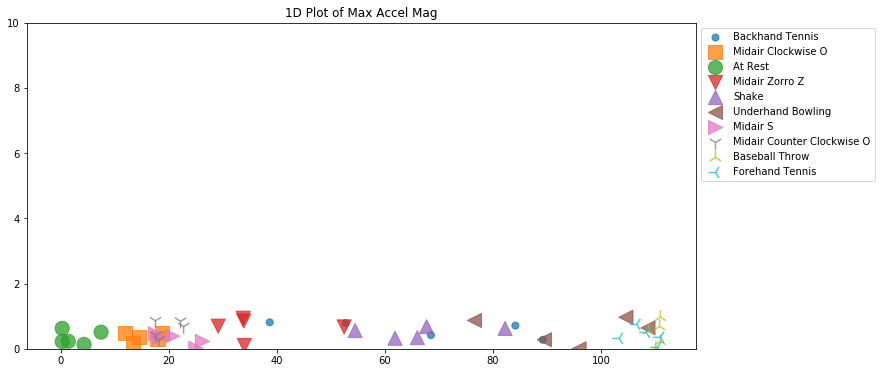

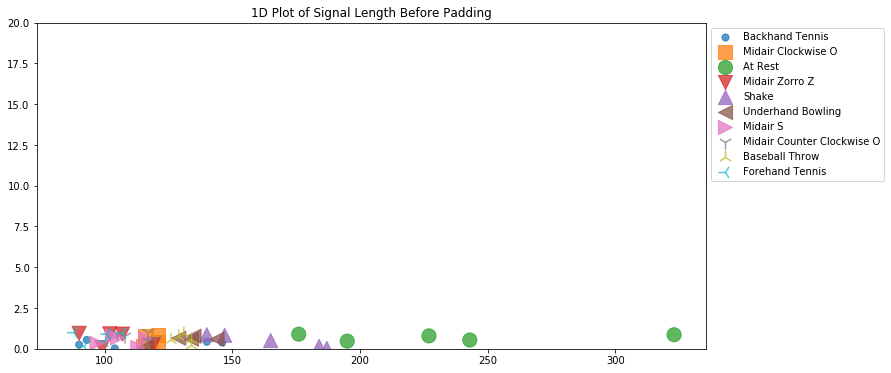

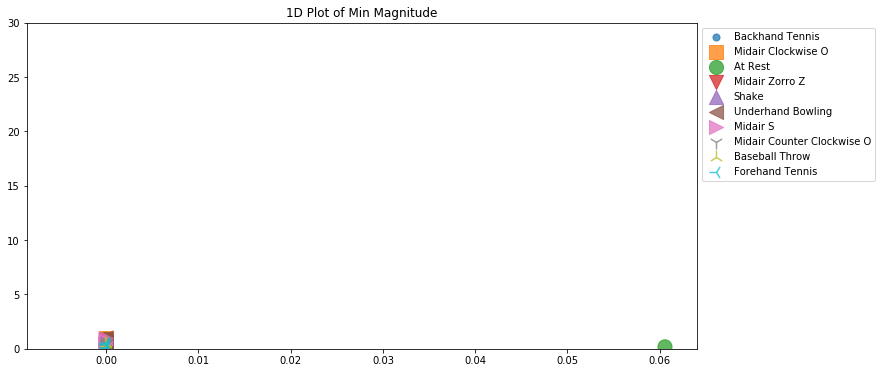

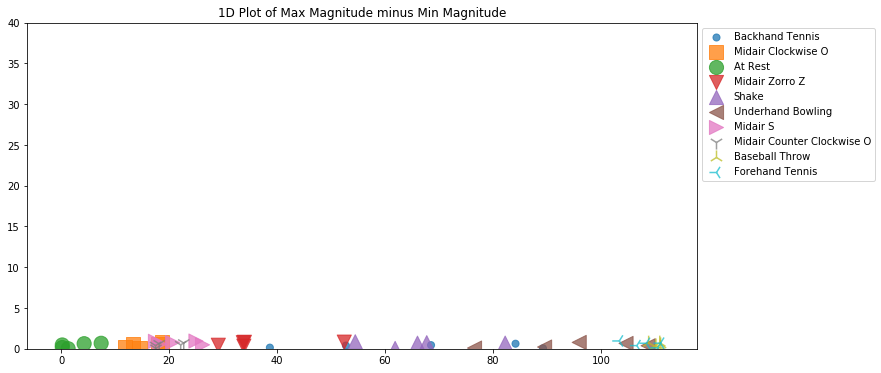

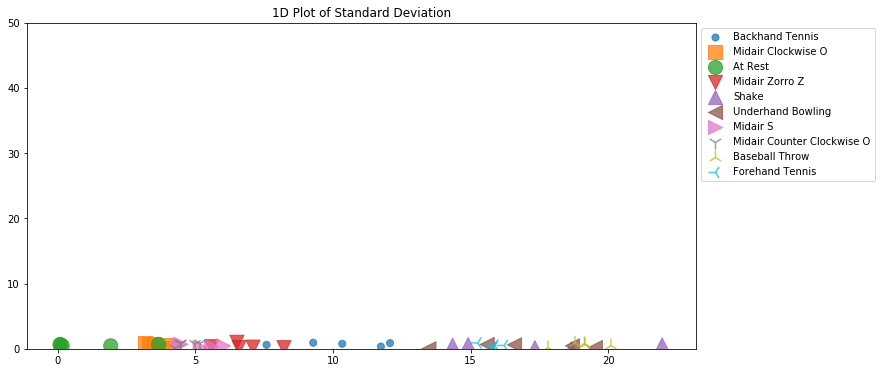

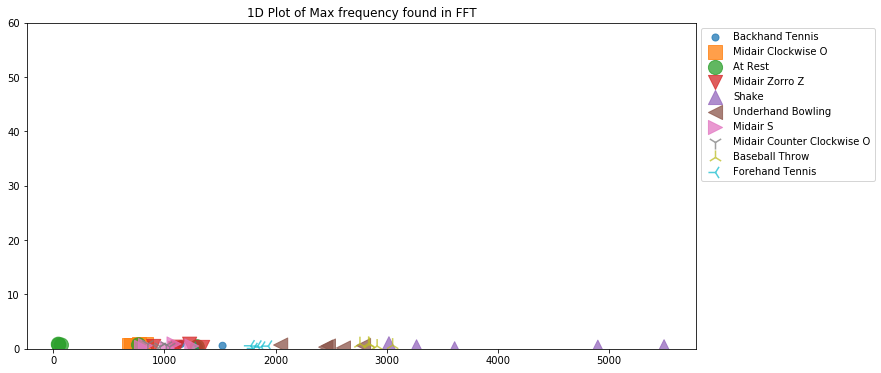

In [32]:
# Playing around with 1D Explorations of data
# TODO: brainstorm and experiment with at least five features that you think might be highly differentiable in the 
# gesture dataset. I've started by plotting two simple features: the maximum magnitude and the length of the trial

import itertools

mapMarkerToDesc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

# Plots the maximum magnitude of each trial's acceleration signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.mag.max() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Max Accel Mag")
plt.show()


# Plots the length of each gesture trial
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.signalLengthBeforePadding for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,20))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Signal Length Before Padding")
plt.show()

# Add your own down here!

# custom 2 - min magnitude
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.mag.min() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,30))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Min Magnitude")
plt.show()

# custom 3 = diff between min and max magnitude
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list((trial.accel.mag.max() - trial.accel.mag.min()) for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,40))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Max Magnitude minus Min Magnitude")
plt.show()


# custom 4 - std deviation of the magnitude
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(np.std(trial.accel.mag) for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,50))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Standard Deviation")
plt.show()


# custom five
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(np.absolute(np.fft.fft(trial.accel.mag)).max() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,60))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Max frequency found in FFT")
plt.show()


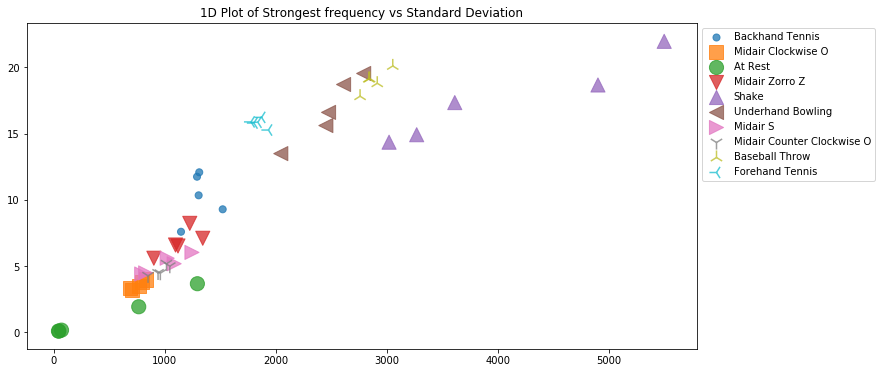

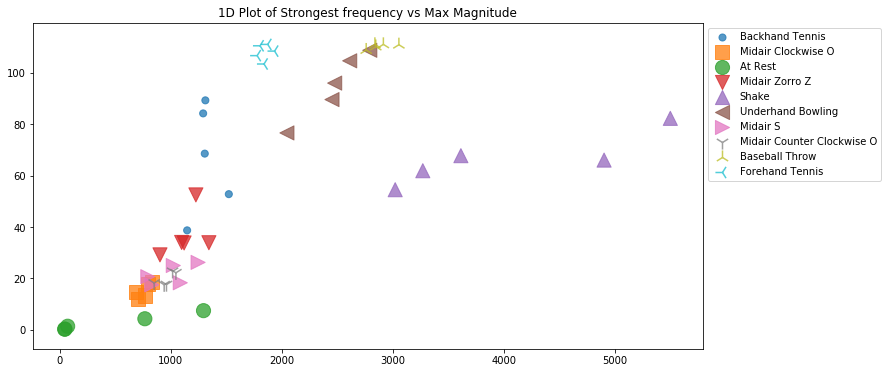

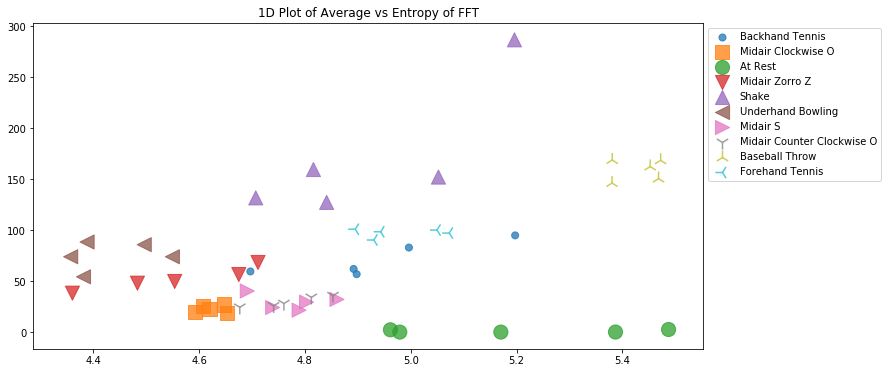

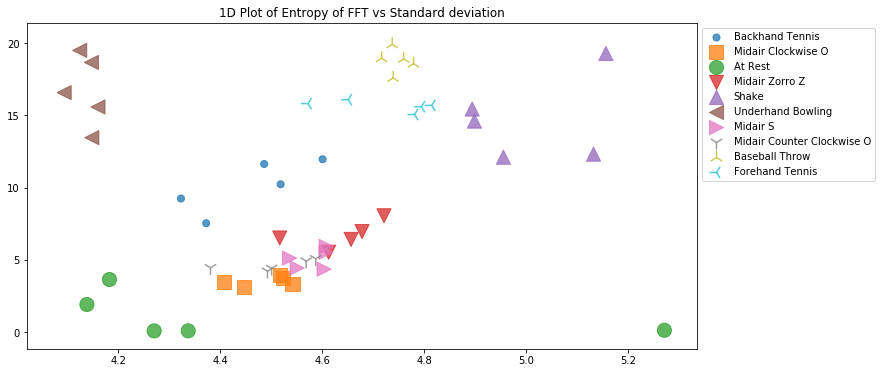

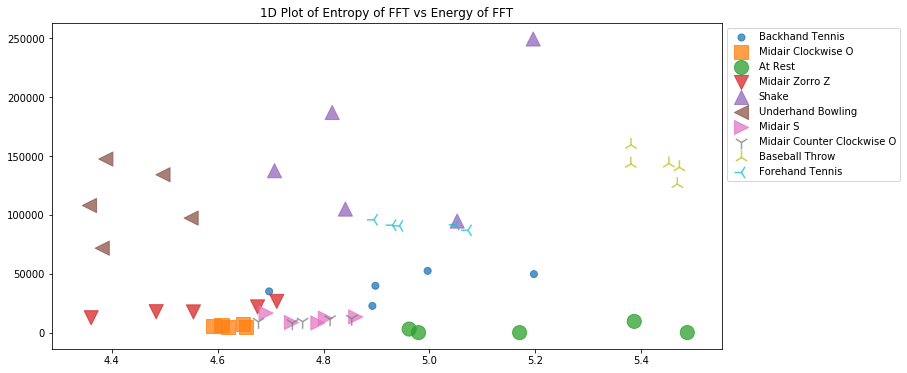

In [33]:
# Now explore the discriminability of 2 dimensions!
# For this exercise, you're going to explore these features in 2D by combining them. Please wait
# to complete this exercise until we get to it in class
# I purposefully did not give you skeleton code here. Please copy/paste a section from the above cell
# and adapt it to plot two features at a time in a scatter plot
from scipy import stats, signal

#custom 1
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(np.absolute(np.fft.fft(trial.accel.mag)).max() for trial in trials)
    y = list(np.std(trial.accel.mag) for trial in trials)
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)


plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Strongest frequency vs Standard Deviation")
plt.show()

# # 
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(np.absolute(np.fft.fft(trial.accel.mag)).max() for trial in trials)
    y = list(trial.accel.mag.max() for trial in trials)
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)


plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Strongest frequency vs Max Magnitude")
plt.show()

# entropy vs energy
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(stats.entropy(np.absolute(np.fft.fft(trial.accel.x))) for trial in trials)
    y = list(np.average(np.absolute(np.fft.fft(trial.accel.x))) for trial in trials)
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)


plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Average vs Entropy of FFT")
plt.show()

# entropy vs correlation 
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(stats.entropy(np.absolute(np.fft.fft(trial.accel.mag))) for trial in trials)
    y = list(np.std(applyButterWorthLowPassFilter(trial.accel.mag)) for trial in trials)
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Entropy of FFT vs Standard deviation")
plt.show()

# entropy vs energy 
def getEnergy(trialAxis):
    fftData = np.absolute(np.fft.fft(trialAxis))
    l = len(fftData)
    f2 = list(pow(d, 2) for d in fftData)
    return sum(f2) / l
    
    
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(stats.entropy(np.absolute(np.fft.fft(trial.accel.x))) for trial in trials)
    y = list(getEnergy(trial.accel.mag) for trial in trials)
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Entropy of FFT vs Energy of FFT")
plt.show()

Results with Jon's dataset

At Rest: 4/5 (80.0%)
Backhand Tennis: 4/5 (80.0%)
Baseball Throw: 3/5 (60.0%)
Forehand Tennis: 4/5 (80.0%)
Midair Clockwise O: 5/5 (100.0%)
Midair Counter Clockwise O: 4/5 (80.0%)
Midair S: 5/5 (100.0%)
Midair Zorro Z: 4/5 (80.0%)
Shake: 5/5 (100.0%)
Underhand Bowling: 2/5 (40.0%)

Total Euclidean distance accuracy 80.0%



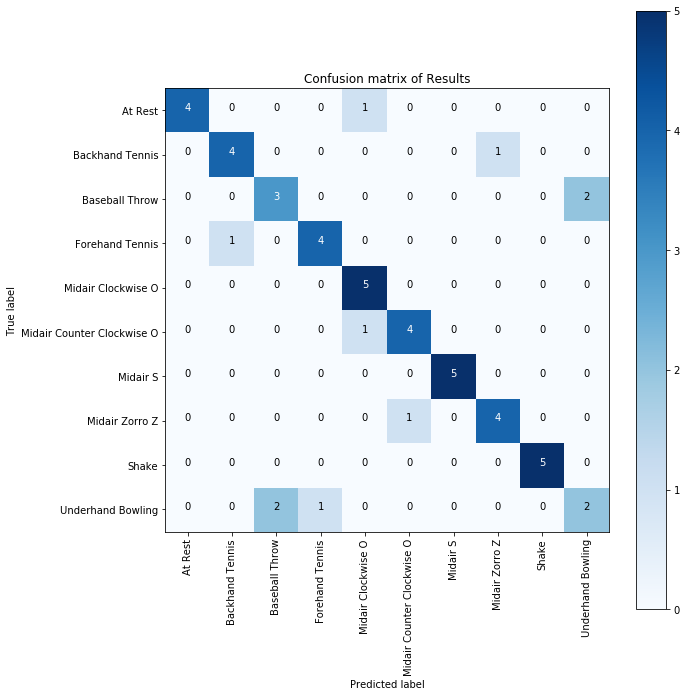

In [34]:
# Take test vs training folds and do Euclidean distance comparison on Jon's data set
from scipy.spatial import distance

numFolds = 5
foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials, numFolds, True)
mapGestureToCorrectMatches = {}
numTrialsTotal = len(foldToMapGestureToTrial) * len(foldToMapGestureToTrial[0])

y_true = []
y_pred = []

for gestureName in gestureNamesSorted:
    mapGestureToCorrectMatches[gestureName] = 0

for i in range(0, len(foldToMapGestureToTrial)):
    trainingFolds = foldToMapGestureToTrial.copy()
    testFold = trainingFolds.pop(i)

    for testGestureName, testTrial in testFold.items():
        currentLowestDistance = 99999999999
        currentMatchedTrial = ""
        y_true.append(testGestureName)
        
        for fold in trainingFolds:
            for trainingGestureName, trainingTrial in fold.items():
                # trial.accel.x, trial.accel.y, trial.accel.z, trial.accel.mag
                euclideanDist = distance.euclidean(trainingTrial.accel.mag,testTrial.accel.mag)
                if euclideanDist < currentLowestDistance:
                    currentLowestDistance = euclideanDist
                    currentMatchedTrial = trainingTrial
        
        # test prediction
        y_pred.append(currentMatchedTrial.gestureName)
        if testTrial.gestureName == currentMatchedTrial.gestureName:
            mapGestureToCorrectMatches[testTrial.gestureName] += 1 
                
totalCorrectMatches = 0
print("Results with Jon's dataset\n")
for gesture in mapGestureToCorrectMatches:
    correctMatches = mapGestureToCorrectMatches[gesture]
    print("{}: {}/{} ({}%)".format(gesture, correctMatches, numFolds, correctMatches / 5 * 100))
    totalCorrectMatches += mapGestureToCorrectMatches[gesture]
    
print("\nTotal Euclidean distance accuracy {}%\n".format(totalCorrectMatches / numTrialsTotal * 100))

cm = confusion_matrix(y_true, y_pred, gestureNamesSorted)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=gestureNamesSorted, title='Confusion matrix of Results')
plt.show()

Results with My dataset

At Rest: 10/10 (100.0%)
Backhand Tennis: 8/10 (80.0%)
Baseball Throw: 2/10 (20.0%)
Forehand Tennis: 9/10 (90.0%)
Midair Clockwise O: 9/10 (90.0%)
Midair Counter Clockwise O: 7/10 (70.0%)
Midair S: 10/10 (100.0%)
Midair Zorro Z: 10/10 (100.0%)
Shake: 9/10 (90.0%)
Underhand Bowling: 9/10 (90.0%)
Your Custom Gesture: 9/10 (90.0%)

Total Euclidean distance accuracy 83.63636363636363%



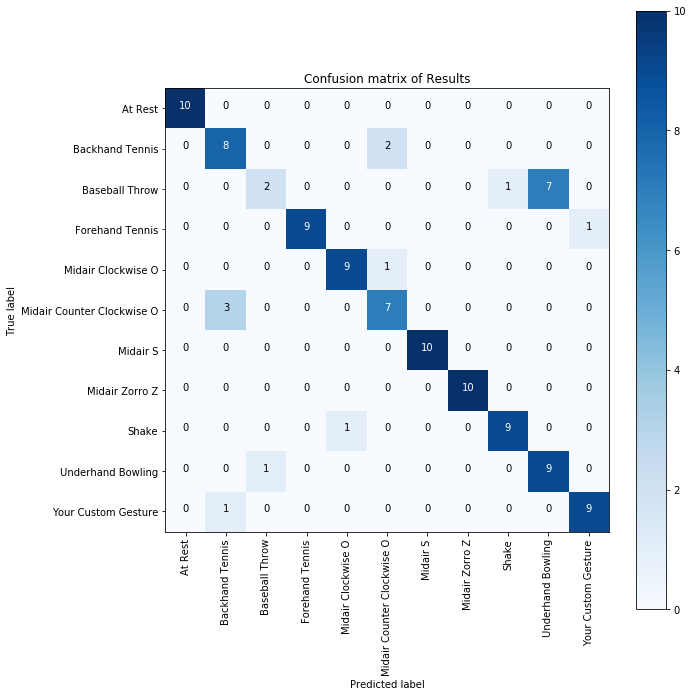

In [35]:
# Take test vs training folds and do Euclidean distance comparison on My data set
from scipy.spatial import distance

numFolds = 10
foldToMapMyGestureToTrial = generate_kfolds(mapMyGestureToTrials, numFolds, True)
mapMyGestureToCorrectMatches = {}
numTrialsTotal = len(mapMyGestureToTrials.keys()) * numFolds
y_true = []
y_pred = []

for myGestureName in myGestureNamesSorted:
    mapMyGestureToCorrectMatches[myGestureName] = 0

for i in range(0, len(foldToMapMyGestureToTrial)):
    trainingFolds = foldToMapMyGestureToTrial.copy()
    testFold = trainingFolds.pop(i)

    for testGestureName, testTrial in testFold.items():
        currentLowestDistance = 99999999999
        currentMatchedGesture = ""
        y_true.append(testGestureName)
        
        for fold in trainingFolds:
            for trainingGestureName, trainingTrial in fold.items():
                # trial.accel.x, trial.accel.y, trial.accel.z, trial.accel.mag
                euclideanDist = distance.euclidean(trainingTrial.accel.mag,testTrial.accel.mag)
                if euclideanDist < currentLowestDistance:
                    currentLowestDistance = euclideanDist
                    currentMatchedGesture = trainingGestureName
#         print("Matched {} with {} with a euclidean distance of {}".format(testTrial.gestureName, currentMatchedTrial.gestureName, currentLowestDistance))
        y_pred.append(currentMatchedGesture)
        if testGestureName == currentMatchedGesture:
#             print("incrementing {},{}".format(testGestureName,currentMatchedGesture))
            mapMyGestureToCorrectMatches[testTrial.gestureName] += 1 
                
totalCorrectMatches = 0
print("Results with My dataset\n")
for gesture in mapMyGestureToCorrectMatches:
    correctMatches = mapMyGestureToCorrectMatches[gesture]
    print("{}: {}/{} ({}%)".format(gesture, correctMatches, numFolds, correctMatches / numFolds * 100))
    totalCorrectMatches += mapMyGestureToCorrectMatches[gesture]
    
print("\nTotal Euclidean distance accuracy {}%\n".format(totalCorrectMatches / numTrialsTotal * 100))

cm = confusion_matrix(y_true, y_pred, myGestureNamesSorted)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=myGestureNamesSorted, title='Confusion matrix of Results')
plt.show()

In [36]:
from scipy import stats, signal
from scipy.signal import butter, lfilter

def extract_features(trial):
    features = []
    
    # apply butterworth filter to data    
    butterX = applyButterWorthLowPassFilter(trial.accel.x)
    butterY = applyButterWorthLowPassFilter(trial.accel.y)
    butterZ = applyButterWorthLowPassFilter(trial.accel.z)
    
    # fourier transform each axis
    fftDataX = np.absolute(np.fft.fft(trial.accel.x))
    fftDataY = np.absolute(np.fft.fft(trial.accel.y))
    fftDataZ = np.absolute(np.fft.fft(trial.accel.z))
    
    # fourier transform each axis of gyro 
    fftDataGryoX = np.absolute(np.fft.fft(trial.gyro.x))
    fftDataGryoY = np.absolute(np.fft.fft(trial.gyro.y))
    fftDataGryoZ = np.absolute(np.fft.fft(trial.gyro.z))
    
    # entropy 
    features.append(stats.entropy(fftDataX))
    features.append(stats.entropy(fftDataY))
    features.append(stats.entropy(fftDataZ))
    
    # energy 
#     features.append(getEnergy(trial.accel.x))
#     features.append(getEnergy(trial.accel.y))
#     features.append(getEnergy(trial.accel.z))
    
    # average accel
    features.append(np.average(butterX))
    features.append(np.average(butterY))
    features.append(np.average(butterZ))
    
    # median accel
    features.append(np.median(butterX))
    features.append(np.median(butterY))
    features.append(np.median(butterZ))
    
    # standard deviation
    features.append(np.std(butterX))
    features.append(np.std(butterY))
    features.append(np.std(butterZ))
    
    # std of gryo 
    features.append(np.std(trial.gyro.x))
    features.append(np.std(trial.gyro.y))
    features.append(np.std(trial.gyro.z))
    
    # average gryo
    features.append(np.average(trial.gyro.x))
    features.append(np.average(trial.gyro.y))
    features.append(np.average(trial.gyro.z))
    
    # median gyro
#     features.append(np.median(trial.gyro.x))
#     features.append(np.median(trial.gyro.y))
#     features.append(np.median(trial.gyro.z))
    
    # entropy of gyro
    features.append(stats.entropy(fftDataGryoX))
    features.append(stats.entropy(fftDataGryoY))
    features.append(stats.entropy(fftDataGryoZ))
    
    # correlation between each axis
#     xyCorrelation = signal.correlate(butterX, butterY)
#     xzCorrelation = signal.correlate(butterX, butterZ)
#     yzCorrelation = signal.correlate(butterY, butterZ)
#     for p in xyCorrelation:
#         features.append(p)
#     for p in xzCorrelation:
#         features.append(p)
#     for p in yzCorrelation:
#         features.append(p)
    
    return features

SVM Results with Jon's dataset

At Rest: 5/5 (100.0%)
Backhand Tennis: 4/5 (80.0%)
Baseball Throw: 5/5 (100.0%)
Forehand Tennis: 5/5 (100.0%)
Midair Clockwise O: 5/5 (100.0%)
Midair Counter Clockwise O: 5/5 (100.0%)
Midair S: 4/5 (80.0%)
Midair Zorro Z: 5/5 (100.0%)
Shake: 4/5 (80.0%)
Underhand Bowling: 4/5 (80.0%)

Total SVM classifier accuracy 92.0%



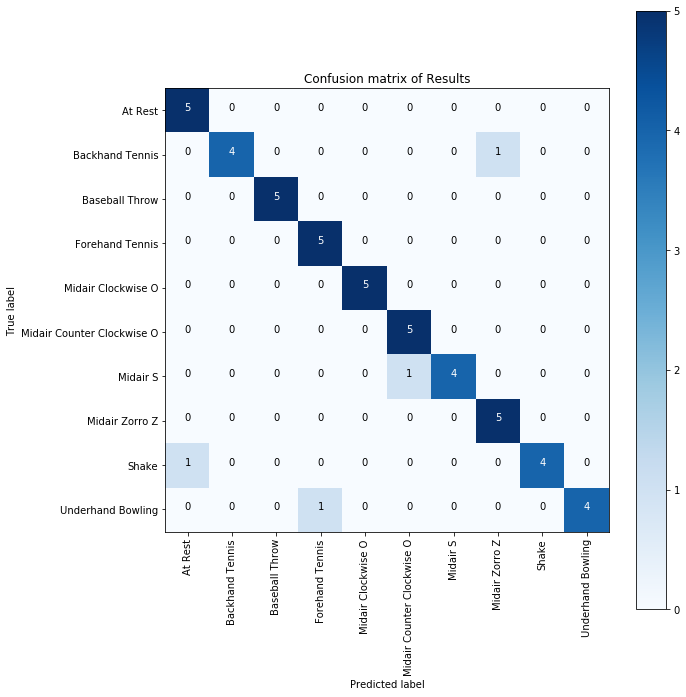

In [37]:
# K-fold cross validation of SVM classifier on Jon's data set
from sklearn import svm

numFolds = 5
foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials, numFolds, True)
mapGestureToCorrectMatches = {}
numTrialsTotal = len(foldToMapGestureToTrial) * len(foldToMapGestureToTrial[0])
y_true = []
y_pred = []

for gestureName in gestureNamesSorted:
    mapGestureToCorrectMatches[gestureName] = 0

for i in range(0, len(foldToMapGestureToTrial)):
    trainingFolds = foldToMapGestureToTrial.copy()
    testFold = trainingFolds.pop(i)

    trainingData = []
    classLabels = np.array([])
    
    # build training data for this set of folds
    for fold in trainingFolds:
        for trainingGestureName, trainingTrial in fold.items():
            features = extract_features(trainingTrial)
            trainingData.append(features)
            classLabels = np.append(classLabels, trainingGestureName)

    # train SVM
    clf = svm.SVC()
    clf.fit(np.array(trainingData), classLabels) 
    
    # make predictions for this test set
    for testGestureName, testTrial in testFold.items():
        features = extract_features(testTrial)
        svmPrediction = clf.predict([features])
        y_true.append(testGestureName)
        y_pred.append(svmPrediction)
        
        if testGestureName == svmPrediction[0]:
            mapGestureToCorrectMatches[testGestureName] += 1
                
totalCorrectMatches = 0
print("SVM Results with Jon's dataset\n")
for gesture in mapGestureToCorrectMatches:
    c = mapGestureToCorrectMatches[gesture]
    print("{}: {}/{} ({}%)".format(gesture, c, numFolds, c / numFolds * 100))
    totalCorrectMatches += mapGestureToCorrectMatches[gesture]
    
print("\nTotal SVM classifier accuracy {}%\n".format(totalCorrectMatches / numTrialsTotal * 100))

cm = confusion_matrix(y_true, y_pred, gestureNamesSorted)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=gestureNamesSorted, title='Confusion matrix of Results')
plt.show()

In [14]:
# K-fold cross validation of SVM classifier on My data set
from sklearn import svm

numFolds = 10
foldToMapMyGestureToTrial = generate_kfolds(mapMyGestureToTrials, numFolds, True)
mapMyGestureToCorrectMatches = {}
numTrialsTotal = len(mapMyGestureToTrials.keys()) * numFolds

y_true = []
y_pred = []

for myGestureName in myGestureNamesSorted:
    mapMyGestureToCorrectMatches[myGestureName] = 0

for i in range(0, len(foldToMapMyGestureToTrial)):
    trainingFolds = foldToMapMyGestureToTrial.copy()
    testFold = trainingFolds.pop(i)

    trainingData = []
    classLabels = np.array([])
    
    # build training data for this set of folds
    for fold in trainingFolds:
        for trainingGestureName, trainingTrial in fold.items():
            features = extract_features(trainingTrial)
            trainingData.append(features)
            classLabels = np.append(classLabels, trainingGestureName)

    # train SVM
    clf = svm.SVC()
    clf.fit(np.array(trainingData), classLabels) 
    
    # make predictions for this test set
    for testGestureName, testTrial in testFold.items():
        features = extract_features(testTrial)
        svmPrediction = clf.predict([features])
        y_true.append(testGestureName)
        y_pred.append(svmPrediction)
        
        if testGestureName == svmPrediction[0]:
            mapMyGestureToCorrectMatches[testGestureName] += 1
                
totalCorrectMatches = 0
print("SVM Results with My dataset\n")
for gesture in mapMyGestureToCorrectMatches:
    c = mapMyGestureToCorrectMatches[gesture]
    print("{}: {}/{} ({}%)".format(gesture, c, numFolds, c / numFolds * 100))
    totalCorrectMatches += mapMyGestureToCorrectMatches[gesture]
    
print("\nTotal SVM classifier accuracy {}%\n".format(totalCorrectMatches / numTrialsTotal * 100))

cm = confusion_matrix(y_true, y_pred, gestureNamesSorted)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=gestureNamesSorted, title='Confusion matrix of Results')
plt.show()

NameError: name 'generate_kfolds' is not defined

# Sandbox
Everything below here is a Sandbox for you to play. You could do this in another Jupyter Notebook but I often have some cells at the bottom of my notebook that let's me experiment with and play with Python and the numpy, scipy, etc. libraries. I've added some example playground cells that I used when making the assignment.

Feel free to delete all of these cells but I thought they might be informative for you.

In [ ]:
# Testing to see if the numpy 'where' method supports string matching
a = np.array(['apple', 'orange', 'apple', 'banana'])

indicesWhereThereAreApples = np.where(a == 'apple')

print (indicesWhereThereAreApples)
print (a[indicesWhereThereAreApples])

In [ ]:
# Playing around with classes in Python 3. Notice how just like in Javascript, you can add a new member variable
# just by starting to use it!

class DummyClass:
    def __init__(self, variable):
        self.testVar = variable
        

dummy = DummyClass(5)
print(dummy.testVar)
dummy.newVar = 7 # added a new member variable called newVar here. Cool!
print(dummy.newVar)
vars(dummy) # prints out the member variables of the class

In [ ]:
# Experimenting with how folding and unfolding tuples work
testTuple = (1,2,3,4,5,6,7,8,9,10)
print(testTuple)
print(*testTuple)
print(*testTuple[5:])

In [ ]:
# Experimenting with how we delete things out of lists
import random
testDict = {"a":1, "c":3, "d":4}
a = list(testDict.keys())
print(a)
random.shuffle(a)
print(a)
del a[1]
print(a)

In [ ]:
# Playing around with how we can split up and combine lists in Python
testList = [1, 2, 3, 4, 5]
index = 4
print(testList[0:index] + testList[index + 1:5])

index = 3
print(testList[0:index] + testList[index + 1:5])

print(testList[index:])
print(testList[:index])

In [ ]:
# playing around with numpy subtraction. In order for these operations to work
# the arrays must be of the same size
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([1, 2, 4, 5, 5])
np2 - np1

np3 = [1, 2, 3]

# the (0,2) value tells pad to pad 0 times in the front of array
# and three times to the end of array. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
np3_resized = np.pad(np3, (0, 2), 'constant', constant_values=0)
np3_resized - np2

In [ ]:
# Find Euclidean distance between two numpy vector arrays
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([5, 4, 3, 2, 1])

# First, we'll try numpy's way of determining Euclidean distance
# See: https://stackoverflow.com/a/1401828
npDist = np.linalg.norm(np2 - np1)
print(npDist)

# Next, we'll try scipy's way
# See: https://stackoverflow.com/a/21986532
from scipy.spatial import distance

scipyDist = distance.euclidean(np2,np1)
print(scipyDist)

In [ ]:
# detrend playground
from scipy import signal
a = np.random.rand(50) * 50
print(a)
b = np.array(range(0,50))
c = a + b

fig, axes = plt.subplots()
# axes.plot(a)
# axes.plot(b)
axes.plot(c, label="c (avg={:0.1f})".format(np.mean(c)))
c_detrended = signal.detrend(c)
axes.plot(c_detrended, label="c_detrended (avg={:0.1f})".format(np.mean(c_detrended)))
axes.legend()
